In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
import keras.backend as K

def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [3]:
import dill

custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=0.25)))}

In [4]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# useful for getting number of classes
folders = glob('C:/Users/wweis/Deep Learning/SC6-Net/data/data/data5/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['C:/Users/wweis/Deep Learning/SC6-Net/data/data/data5/train\\Drowsy', 'C:/Users/wweis/Deep Learning/SC6-Net/data/data/data5/train\\Non Drowsy']


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/Users/wweis/Deep Learning/SC6-Net/data/data/data5/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

# validation_set = test_datagen.flow_from_directory(
#         'C:/Users/wweis/Deep Learning/SC6-Net/data/valid',
#         target_size=(224, 224),
#         batch_size=1,
#         class_mode='categorical',
#         shuffle=False,
#         seed=42)

test_set = test_datagen.flow_from_directory('C:/Users/wweis/Deep Learning/SC6-Net/data/data/data5/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 2814 images belonging to 2 classes.
Found 804 images belonging to 2 classes.


In [7]:
from keras.models import load_model

saved_model = load_model("models/5/CE_data5_SC6-Net.h5")
# saved_model = load_model("models/FL_CK+.h5", custom_objects=custom_object)

In [8]:
score_test = saved_model.evaluate(test_set)
# score_test = model.evaluate(test_set)

804/804 [==============================] - 23s 25ms/step - loss: 2.0801 - branch_1_loss: 0.5287 - branch_2_loss: 0.5675 - branch_3_loss: 0.3639 - branch_4_loss: 0.2978 - fine_branch_loss: 0.3222 - branch_1_accuracy: 0.7861 - branch_2_accuracy: 0.7749 - branch_3_accuracy: 0.8607 - branch_4_accuracy: 0.8794 - fine_branch_accuracy: 0.8794


In [9]:
pred = saved_model.predict(test_set)
# pred = model.predict(test_set)

# Get the number of unique labels
num_labels = len(np.unique(test_set.classes))

predicted_class_indices = []

for branch in range(5):
    predicted_class_indices.append(np.argmax(pred[branch],axis=1))

# Define a list of label names
label_names = ['Drowsy', 'Non_Drowsy']

# Compute the accuracy for each label
for branch in range(5):
    predicted_class = predicted_class_indices[branch]

    label_accs = {}
    for label in range(num_labels):
        idx = np.where(test_set.classes == label)[0]
        label_acc = np.mean(predicted_class[idx] == test_set.classes[idx])
        label_accs[label_names[label]] = label_acc

    # Print the accuracy for each label
    for label, acc in label_accs.items():
        print(f"Accuracy for label {label}: {acc:.2f}")
    print("\n")

Accuracy for label Drowsy: 0.60
Accuracy for label Non_Drowsy: 0.97


Accuracy for label Drowsy: 0.57
Accuracy for label Non_Drowsy: 0.98


Accuracy for label Drowsy: 0.79
Accuracy for label Non_Drowsy: 0.94


Accuracy for label Drowsy: 0.85
Accuracy for label Non_Drowsy: 0.91


Accuracy for label Drowsy: 0.82
Accuracy for label Non_Drowsy: 0.94




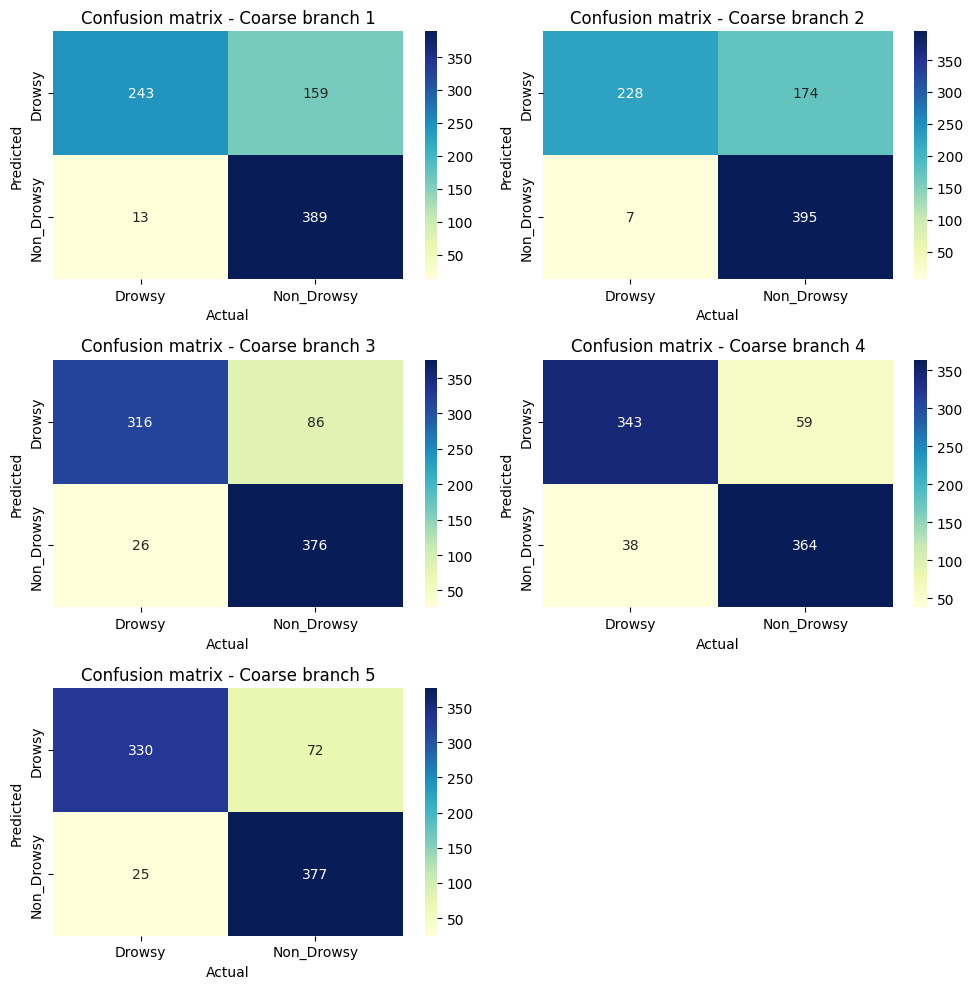

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 10))

# Get the true labels for the test set
y_true = test_set.classes

# Iterate over each branch
for branch in range(5):
    # Compute the confusion matrix for the current branch
    conf_mat = confusion_matrix(y_true, predicted_class_indices[branch])

    df_cm = pd.DataFrame(conf_mat, index=['Drowsy', 'Non_Drowsy'], 
                         columns=['Drowsy', 'Non_Drowsy'])

    # Create a subplot for the current branch
    plt.subplot(3, 2, branch+1)  # Adjust the subplot layout as needed
    plt.title("Confusion matrix - Coarse branch {}".format(branch+1))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")

# Adjust the spacing between subplots if necessary
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
from sklearn.metrics import classification_report

for branch in range(5):
    # Assuming y_true and y_pred are the true and predicted labels
    report = classification_report(y_true, predicted_class_indices[branch])
    print(report)

              precision    recall  f1-score   support

           0       0.95      0.60      0.74       402
           1       0.71      0.97      0.82       402

    accuracy                           0.79       804
   macro avg       0.83      0.79      0.78       804
weighted avg       0.83      0.79      0.78       804

              precision    recall  f1-score   support

           0       0.97      0.57      0.72       402
           1       0.69      0.98      0.81       402

    accuracy                           0.77       804
   macro avg       0.83      0.77      0.76       804
weighted avg       0.83      0.77      0.76       804

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       402
           1       0.81      0.94      0.87       402

    accuracy                           0.86       804
   macro avg       0.87      0.86      0.86       804
weighted avg       0.87      0.86      0.86       804

              preci

In [12]:
branch_predictions = [score_test[6], score_test[7], score_test[8], score_test[9], score_test[10]]

# Assuming you have the predicted probabilities from each model stored in a list
model_predictions = [pred[0], pred[1], pred[2], pred[3], pred[4]]

branch_left = len(model_predictions)

In [13]:
import pandas as pd

for m in range(branch_left-1):
    print(len(model_predictions))
    # Calculate the product of probabilities for each class across all models
    ensemble_pred_probs_product = np.prod(model_predictions, axis=0)
    ensemble_pred_probs_max = np.max(model_predictions, axis=0)
    ensemble_pred_probs_mean = np.mean(model_predictions, axis=0)

    ensemble_pred = [ensemble_pred_probs_product, ensemble_pred_probs_max, ensemble_pred_probs_mean]
    
    class_data = []

    for k in range(len(ensemble_pred)):
        data = []

        for i in range(len(pred[0])):
            sample_data = []
            sample_data.append("Sample " + str(i+1))

            for j in range(len(folders)):
                ensemble_pred_probs = ensemble_pred[k]
                sample_data.append(ensemble_pred_probs[i,j])

            data.append(sample_data)

#         df = pd.DataFrame(data, columns=["Sample", 'Drowsy', 'Non_Drowsy'])
#         df.to_excel("test_"+str(m)+"_"+str(k)+".xlsx", index=False)

        # Get the predicted classes by selecting the class with the highest probability
        ensemble_pred_classes = np.argmax(ensemble_pred_probs, axis=1)

        # Print the ensemble predictions
        for i in range(len(ensemble_pred_classes)):
            class_data.append("Sample" + str(i+1))
            class_data.append(test_set.labels[i])
            class_data.append(ensemble_pred_classes[i])
#             print("Sample", i+1, ": Predicted class:", ensemble_pred_classes[i])

        # Assuming you have the true labels for the validation set stored in a variable
        true_labels = test_set.labels

        # Calculate the accuracy of the ensemble predictions
        accuracy = np.mean(ensemble_pred_classes == true_labels) * 100
        class_data.extend(["Accuracy", "", accuracy])

        print("Ensemble accuracy on the test set: {:.2f}%".format(accuracy))
        
#         df1 = pd.DataFrame(np.array(class_data).reshape(-1, 3), columns=["Sample", 'Actual', 'Predicted'])
#         df1.to_excel("Predicted_test_"+str(m)+".xlsx", index=False)
    
    if(len(model_predictions)>2):
        lowest_accuracy_branch_idx = np.argmin(branch_predictions)
        branch_predictions.pop(lowest_accuracy_branch_idx)
        model_predictions.pop(lowest_accuracy_branch_idx)
    
    print("-----------------------------------------------------------------------------------------------------")

5
Ensemble accuracy on the test set: 87.06%
Ensemble accuracy on the test set: 87.19%
Ensemble accuracy on the test set: 86.69%
-----------------------------------------------------------------------------------------------------
4
Ensemble accuracy on the test set: 87.44%
Ensemble accuracy on the test set: 87.56%
Ensemble accuracy on the test set: 87.69%
-----------------------------------------------------------------------------------------------------
3
Ensemble accuracy on the test set: 88.18%
Ensemble accuracy on the test set: 88.43%
Ensemble accuracy on the test set: 88.18%
-----------------------------------------------------------------------------------------------------
2
Ensemble accuracy on the test set: 88.81%
Ensemble accuracy on the test set: 88.81%
Ensemble accuracy on the test set: 88.81%
-----------------------------------------------------------------------------------------------------


Text(0.5, 25.722222222222214, 'Actual')

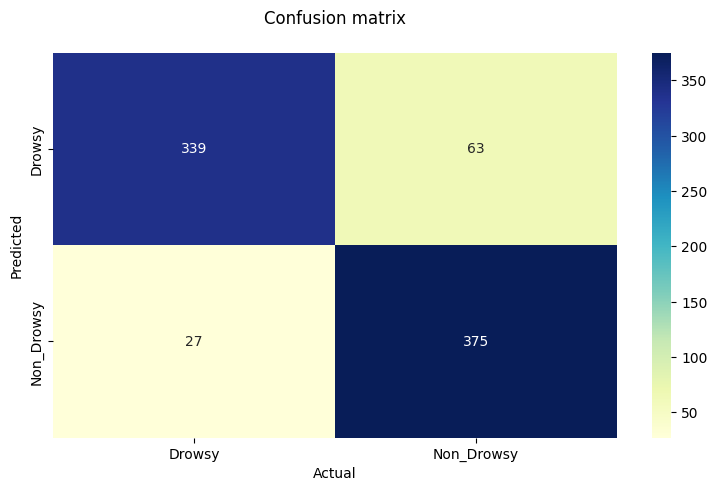

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

pred_labels = np.argmax(ensemble_pred_probs_product, axis=1)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, pred_labels)

df_cm = pd.DataFrame(conf_mat, index=['Drowsy', 'Non_Drowsy'], columns=['Drowsy', 'Non_Drowsy'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")